# Great Motor Price Prediction

## Description

Great Motors deals in used cars, with a huge market base in Nigeria. The company has a unique platform where customers can buy and sell cars. A seller posts details about the vehicle for review by the company’s mechanic on the platform to ascertain the vehicle's value. The company then lists the car for sale at the best price. Great Motors makes its profit by receiving a percentage of the selling price listed on the company platform. To ensure the car's selling price is the best for both the customer selling the vehicle and Great Motors, you have been assigned the task of coming up with a predictive model for determining the price of the car.

## Objective

The objective of this notebook is to predict the price (Amount (Million Naira) the company should sell a car based on the available data (Location, Maker, Model, Year, Colour, Amount (Million Naira), Type, Distance). The objective is the predict the selling price.

## Dataset Preparation

Import necessary libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy import stats
import matplotlib.style as style

import missingno as msn

from category_encoders.binary import BinaryEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

Import Dataset

In [4]:
def import_df(path):
    
    data = pd.read_csv(path)
    return data

df = import_df('Train.csv')
test_df = import_df('Test.csv')
df.sample(n=5).T

,6218,397,6926,1184,6988
VehicleID,VHL12932,VHL12409,VHL19494,VHL14624,VHL16102
Location,Abuja,Lagos,Abuja,Ibadan,Abuja
Maker,Mercedes-Benz,Mercedes-Benz,Kia,Toyota,Toyota
Model,C400,M Class ML350 AWD 4MATIC,Optima,Corolla,Camry
Year,2015.0,2009.0,2017.0,2006.0,2018.0
Colour,Gray,Black,Brown,Black,Black
Amount (Million Naira),18.5,7.1,3.6,2.7,13.5
Type,Foreign Used,Foreign Used,Nigerian Used,NaN,Foreign Used
Distance,99646.0,NaN,NaN,87710.0,NaN


### Dataset Overview

check the missing values for each variables in the train data 

<Axes: >

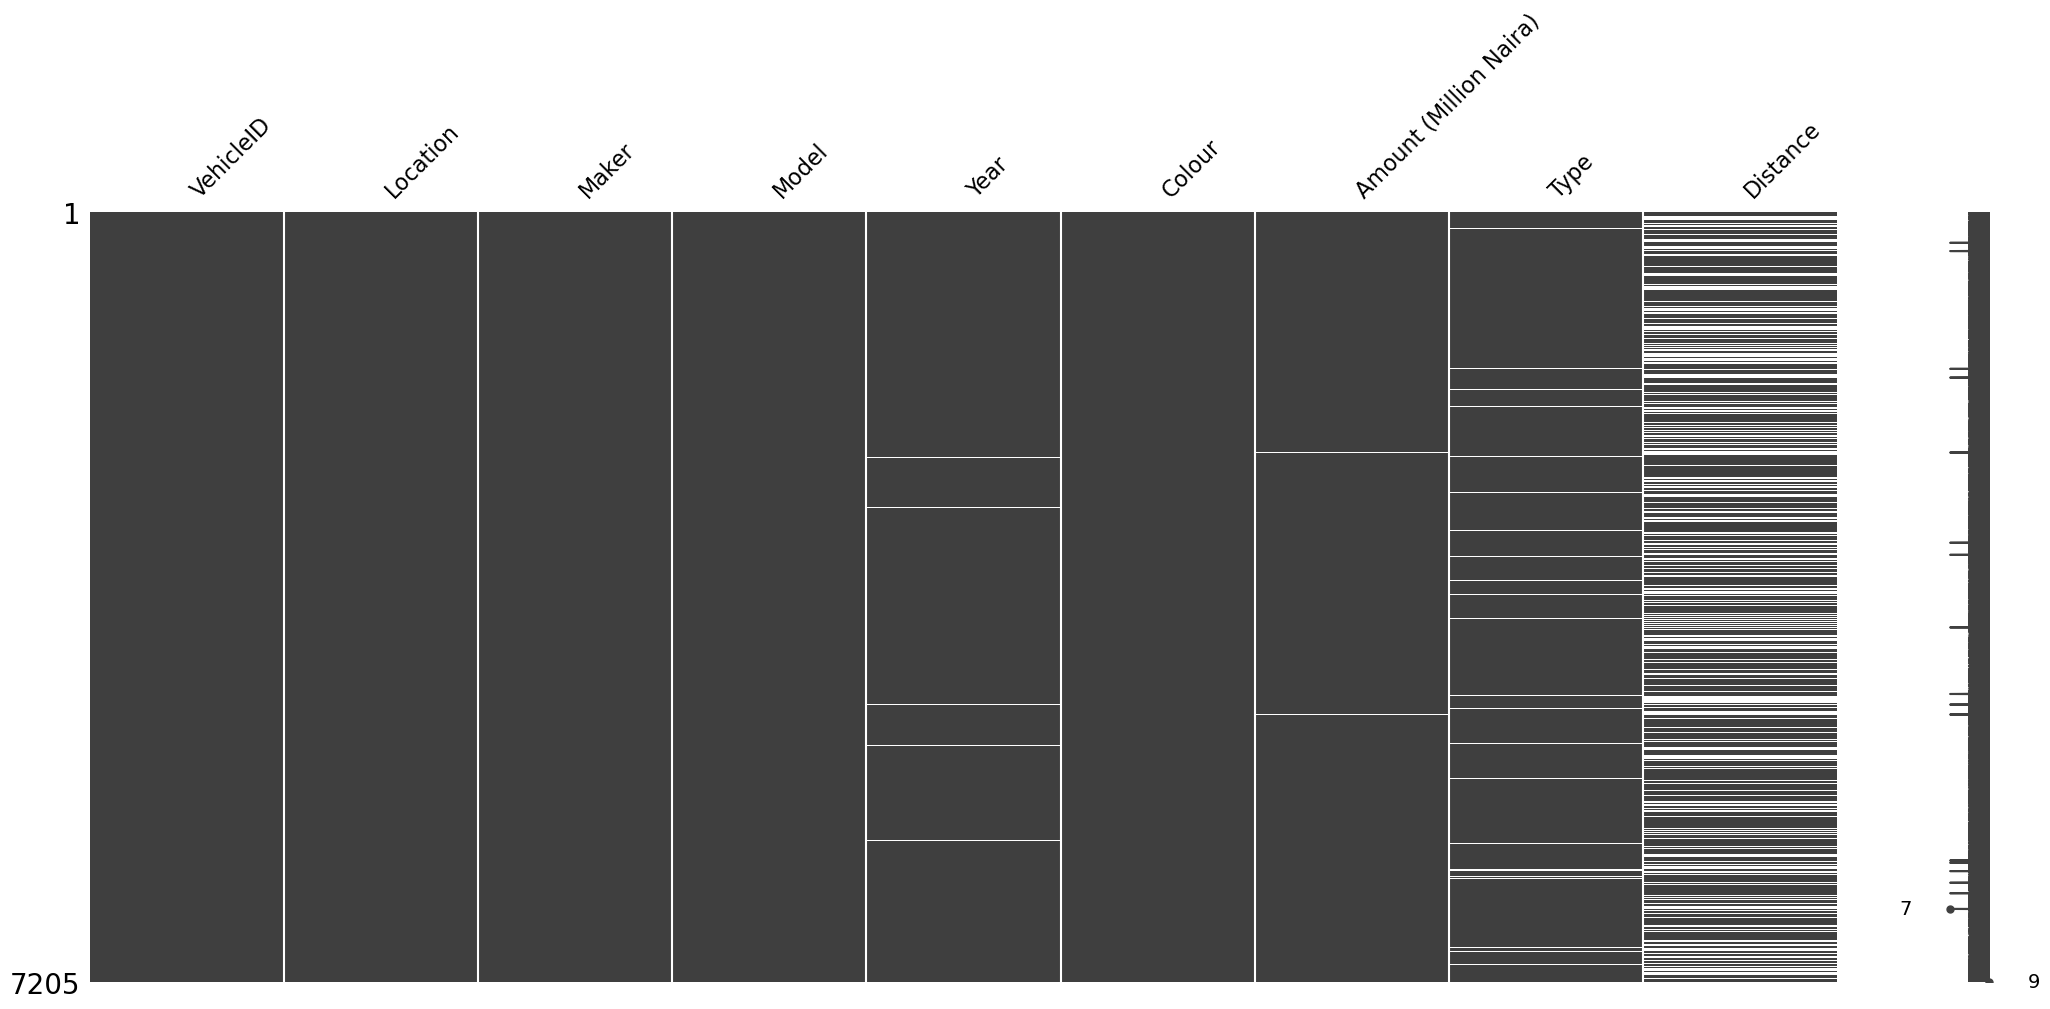

In [5]:
msn.matrix(df)

Obsevation:

Only VehicleID, Location, Maker, Model and Color variables have no missing values. The others with missing values shall be dealt with in subsequent section

Next, check the datatype of the dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7205 entries, 0 to 7204
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VehicleID               7205 non-null   object 
 1   Location                7205 non-null   object 
 2   Maker                   7205 non-null   object 
 3   Model                   7205 non-null   object 
 4   Year                    7184 non-null   float64
 5   Colour                  7205 non-null   object 
 6   Amount (Million Naira)  7188 non-null   float64
 7   Type                    7008 non-null   object 
 8   Distance                4845 non-null   float64
dtypes: float64(3), object(6)
memory usage: 506.7+ KB


In [7]:
# statistical summary

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,7184.0,2011.032712,4.853260,1979.00,2008.0,2011.00,2014.0000,2022.0
Amount (Million Naira),7188.0,11.847999,25.318922,0.45,3.5,5.65,11.6625,456.0
Distance,4845.0,103198.903612,118290.241336,1.00,52352.0,80830.00,117584.0000,1985400.0


Observation

- Year: The average year of the vehicles is 2011, with a standard deviation of 4.85. The oldest vehicle is from 1979, and the newest vehicle is from 2022. The middle 50% of the vehicles are from 2008 to 2014.
- Amount (Million Naira): The average amount of the vehicles is 11.85 million naira, with a standard deviation of 25.32. The cheapest vehicle is 0.45 million naira, and the most expensive vehicle is 456 million naira. The middle 50% of the vehicles are between 3.5 and 11.66 million naira.
- Distance: The average distance traveled by the vehicles is 103198.9 km, with a standard deviation of 118290.2. The least traveled vehicle has 1 km, and the most traveled vehicle has 1985400 km. The middle 50% of the vehicles have traveled between 52352 and 117584 km.

(                        Total Missing Values  Percentage Missing
 Distance                                2360               32.76
 Type                                     197                2.73
 Year                                      21                0.29
 Amount (Million Naira)                    17                0.24,
 <Axes: >)

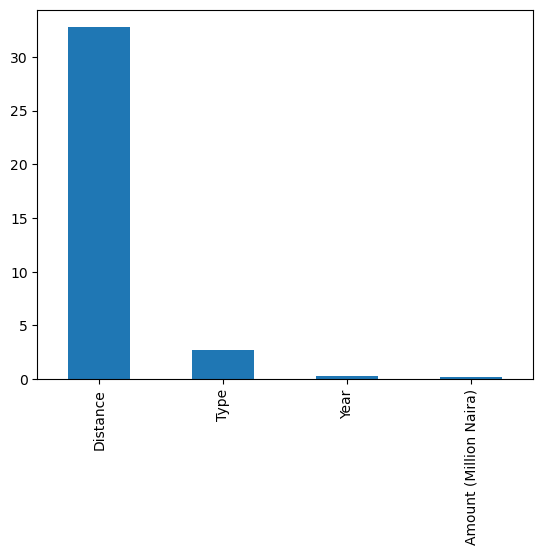

In [8]:
# check percentage of missing values of each variable

def missing_no(data):
    """
    data: dataframe that contains the data
    
    returns a dataframe that contains a column fro total missing values of each variable and percentage of missing value
    """
    total_missing = data.isnull().sum().sort_values(ascending=False)[data.isnull().sum().sort_values(ascending=False) !=0]
    percentage_missing = round(df.isnull().sum()/len(df) *100, 2)[df.isnull().sum().sort_values(ascending=False) !=0]
    dataframe = pd.concat([total_missing, percentage_missing], keys=['Total Missing Values', 'Percentage Missing'],
                    axis=1)
    
    return dataframe, dataframe["Percentage Missing"].plot(kind='bar');

missing_no(df)

Observation 

Distance has the highest number of missing values which accumulated to 32.78% of the total entries

# Plot to Gain Insight 
Focus on Target variable (Amount)

In [9]:
def plot_figs(df, feat):
    
    """
    df: dataframe
    feat: feature of concern
    returns three plots viz; histogram, box plot and probabilty plot
    """
    style.use('fivethirtyeight')
    
    fig = plt.figure(layout='constrained', figsize=(15,15))
    grid = gridspec.GridSpec(3, 3, figure=fig)
    
    ax1 = fig.add_subplot(grid[0,:2])
    ax1.set_title('Histogram')
    sns.histplot(data=df, x=feat, kde=True, ax=ax1, stat='probability')
    
    ax2 = fig.add_subplot(grid[1,:2])
    ax2.set_title('QQ Plot')
    stats.probplot(df.loc[:,feat], plot=ax2)
    
    ax3 = fig.add_subplot(grid[:,2])
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:,feat], orient='v', ax=ax3)

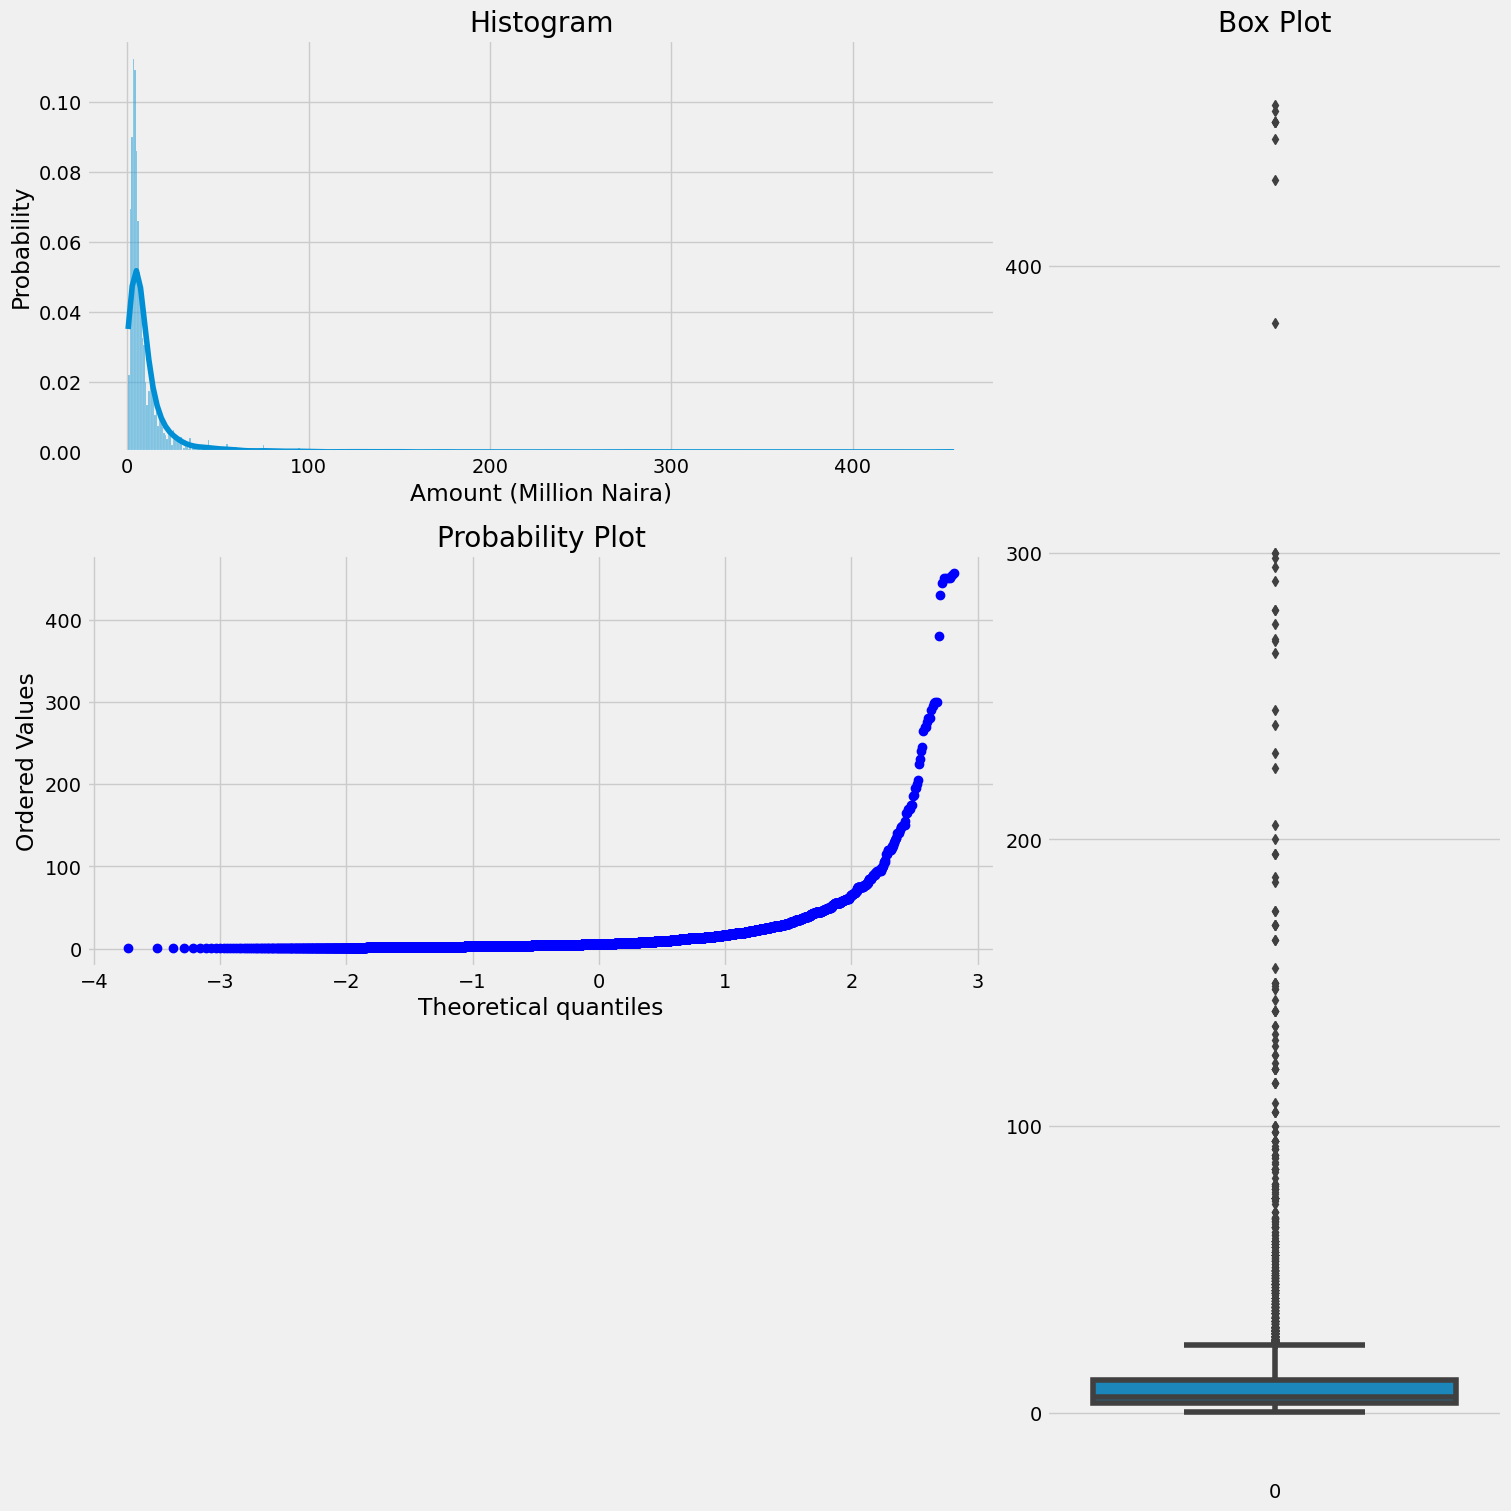

In [10]:
plot_figs(df=df, feat='Amount (Million Naira)')

In [11]:
print(f"Skew is {df['Amount (Million Naira)'].skew()}")

print(f"Kurt is: {df['Amount (Million Naira)'].kurt()}")

Skew is 9.779965790741855
Kurt is: 132.5104523272396


Observations

- The histogram is skewed to the right, indicating most values are clustered towards the lower end.
- The data points form a curve shape, indicating a non-normal distribution
- The box plot also shows outliers as dots beyond the whiskers. 
- The Skewness value is 9.7 which is very high and also indicates that the distribution is extremely right-skewed. 
- In other word, there are some very large values in the variable that pull the mean to the right of the median and mode. This shall be taken care of by transformation later.

- A very high kurtosis indicates the presence of outlier in the dataset


Plot histogram for other numerical variables

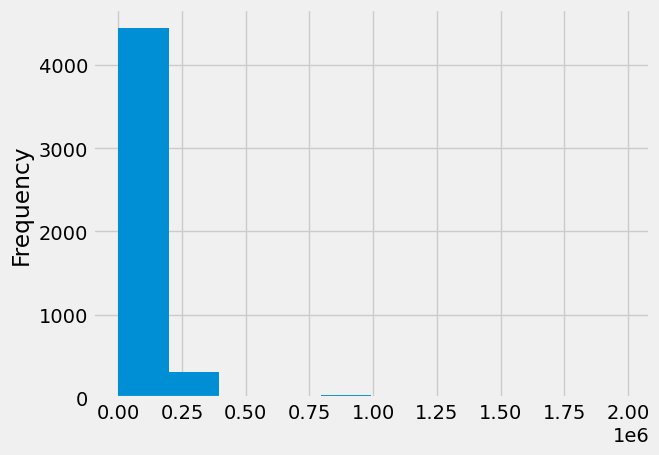

In [12]:
df.Distance.plot(kind='hist');

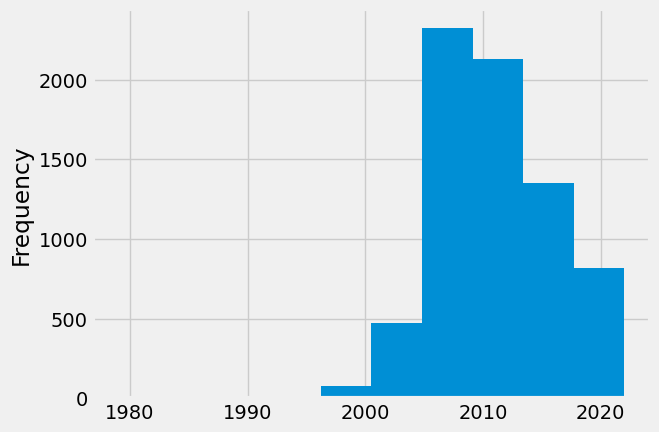

In [13]:
df.Year.plot(kind='hist');

Observation:

- There is a prominent bar at the beginning (Disatance), this indicates that a large number of data points are within the range of 0 and 200,000 km. The plot is skewed to the right, meaning most distance of the vehicles are between 0 and 200,000 km
- The histogram (Year) shows that most vehicles in the dataset are between 1995 and 2020.

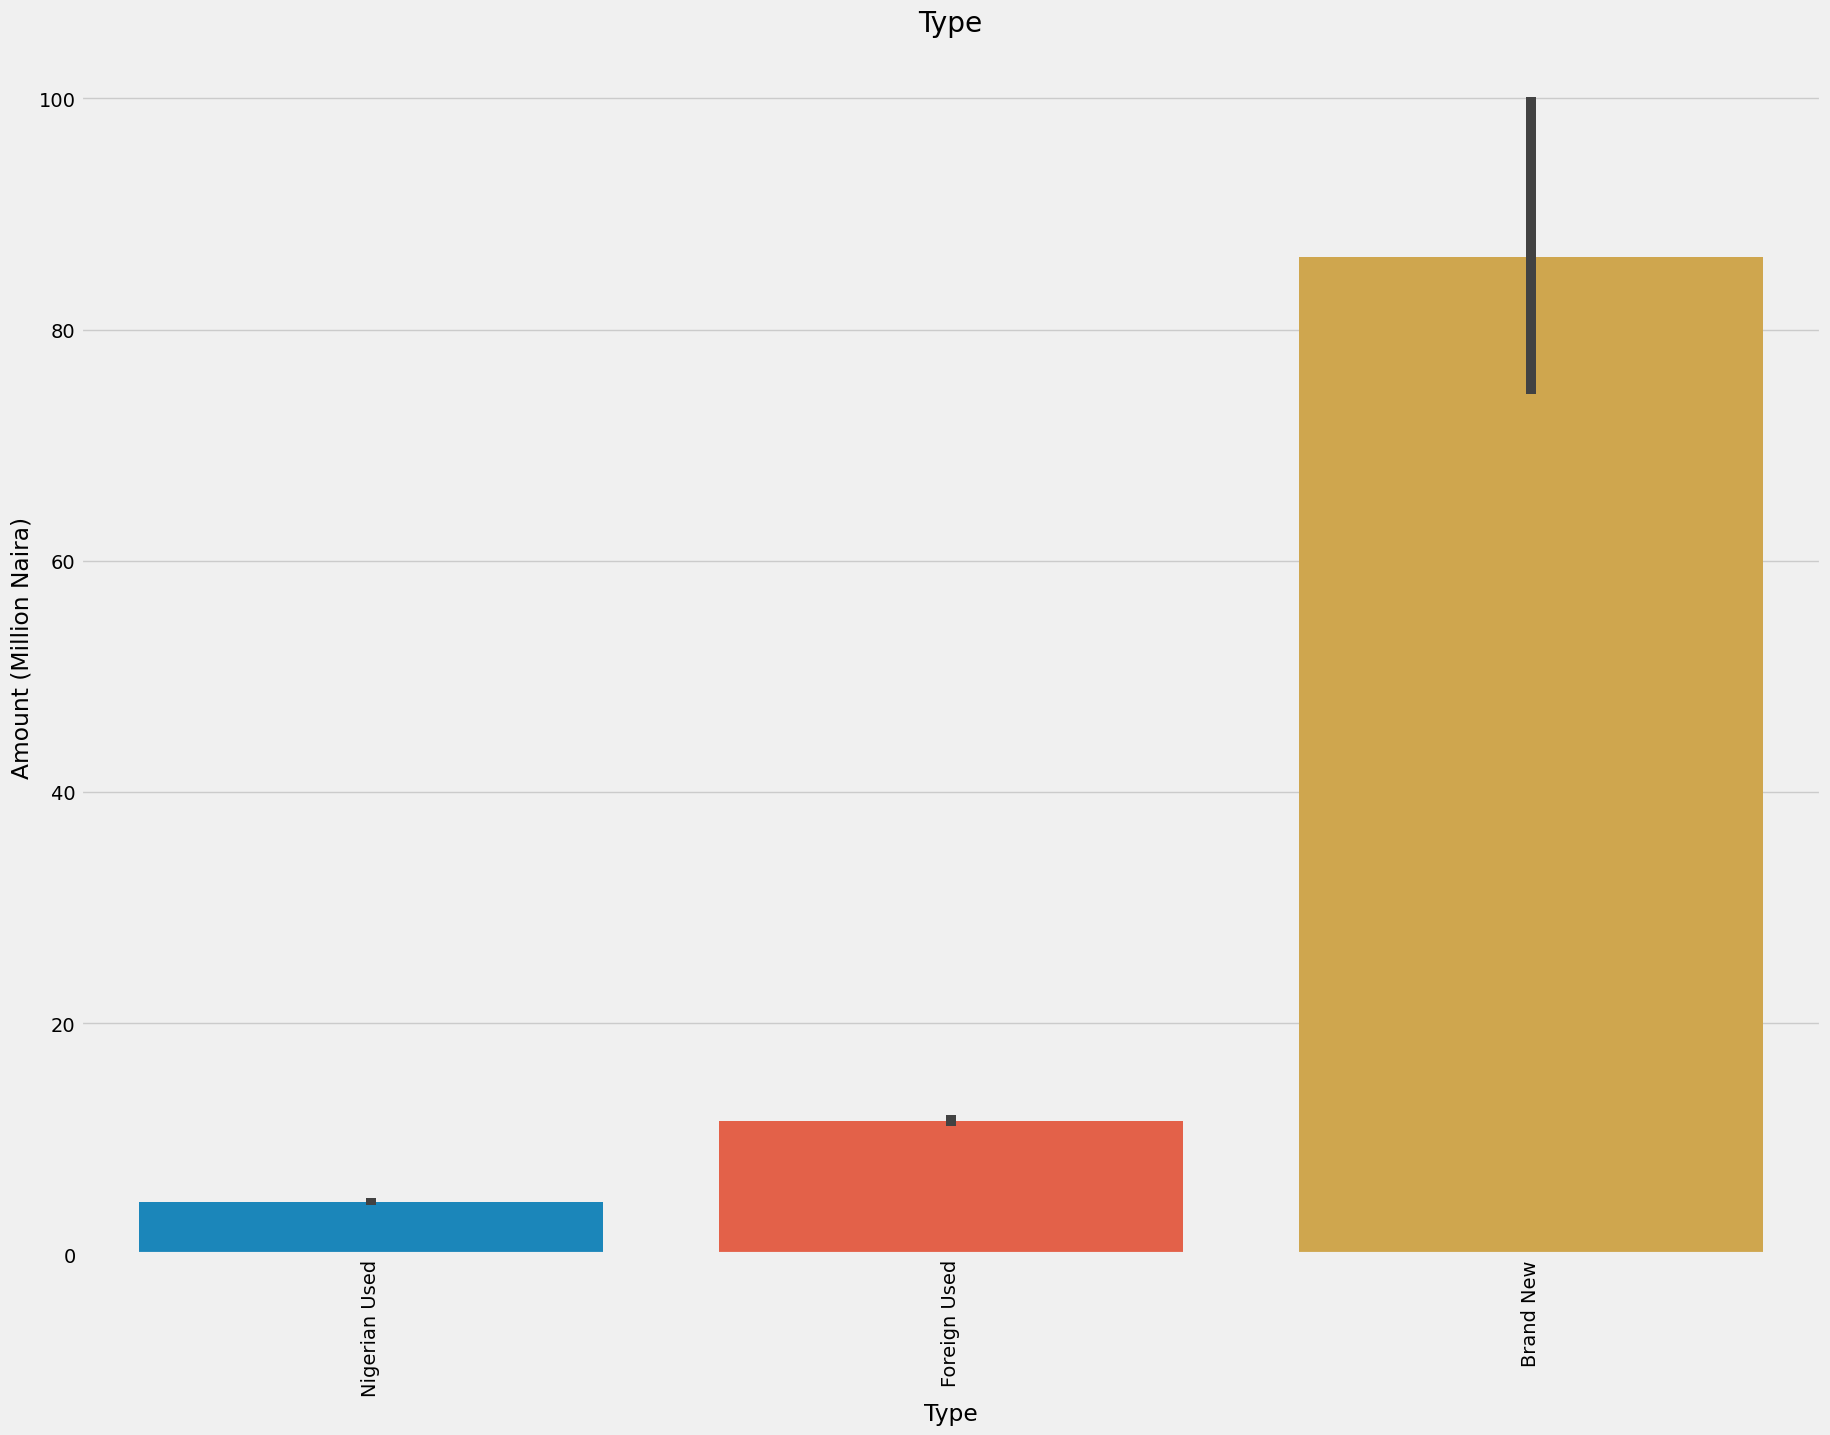

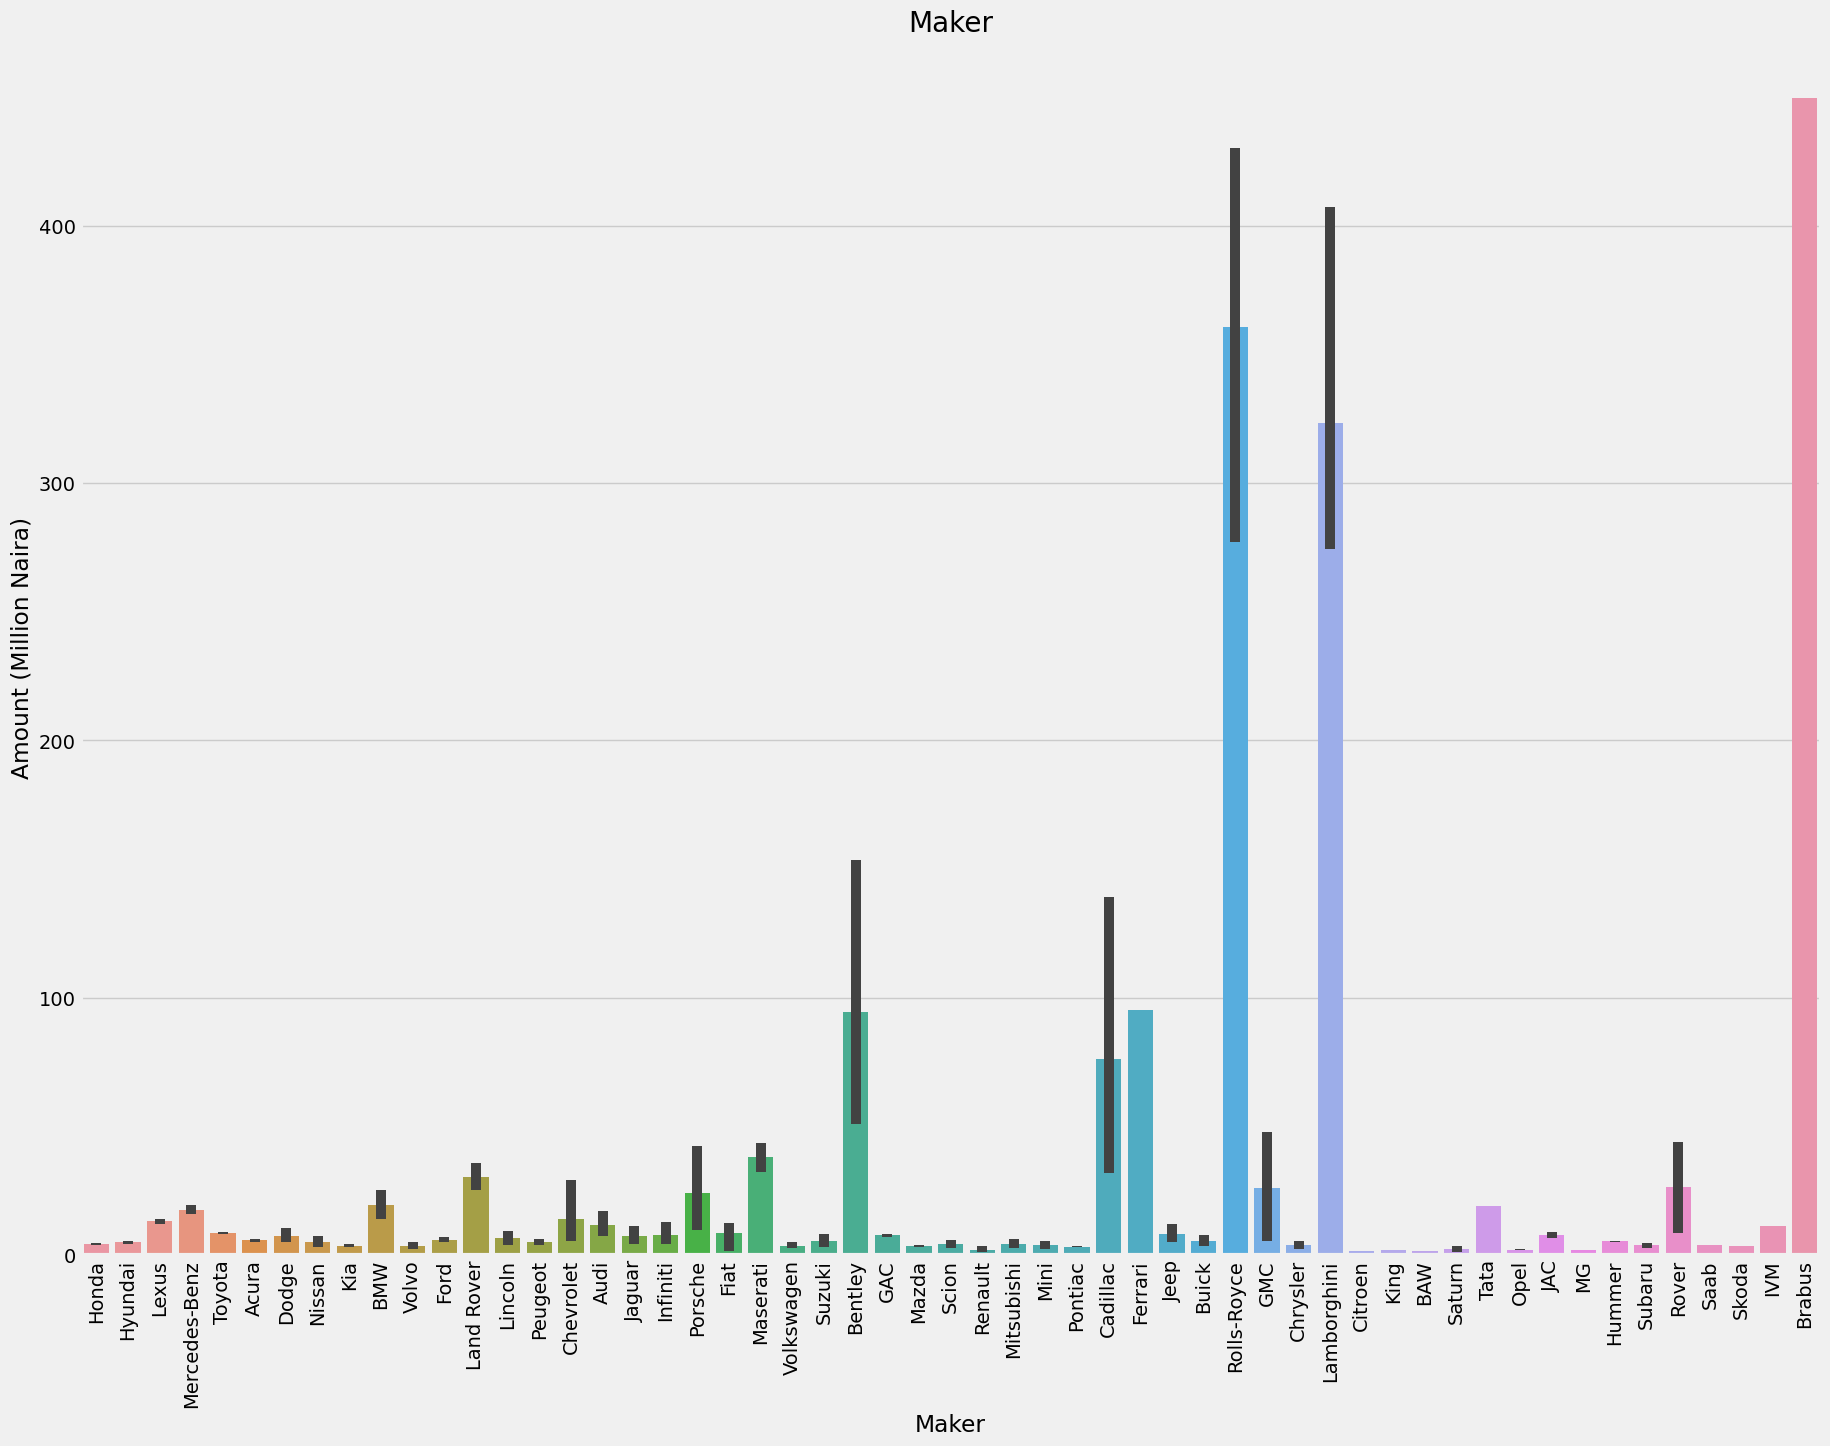

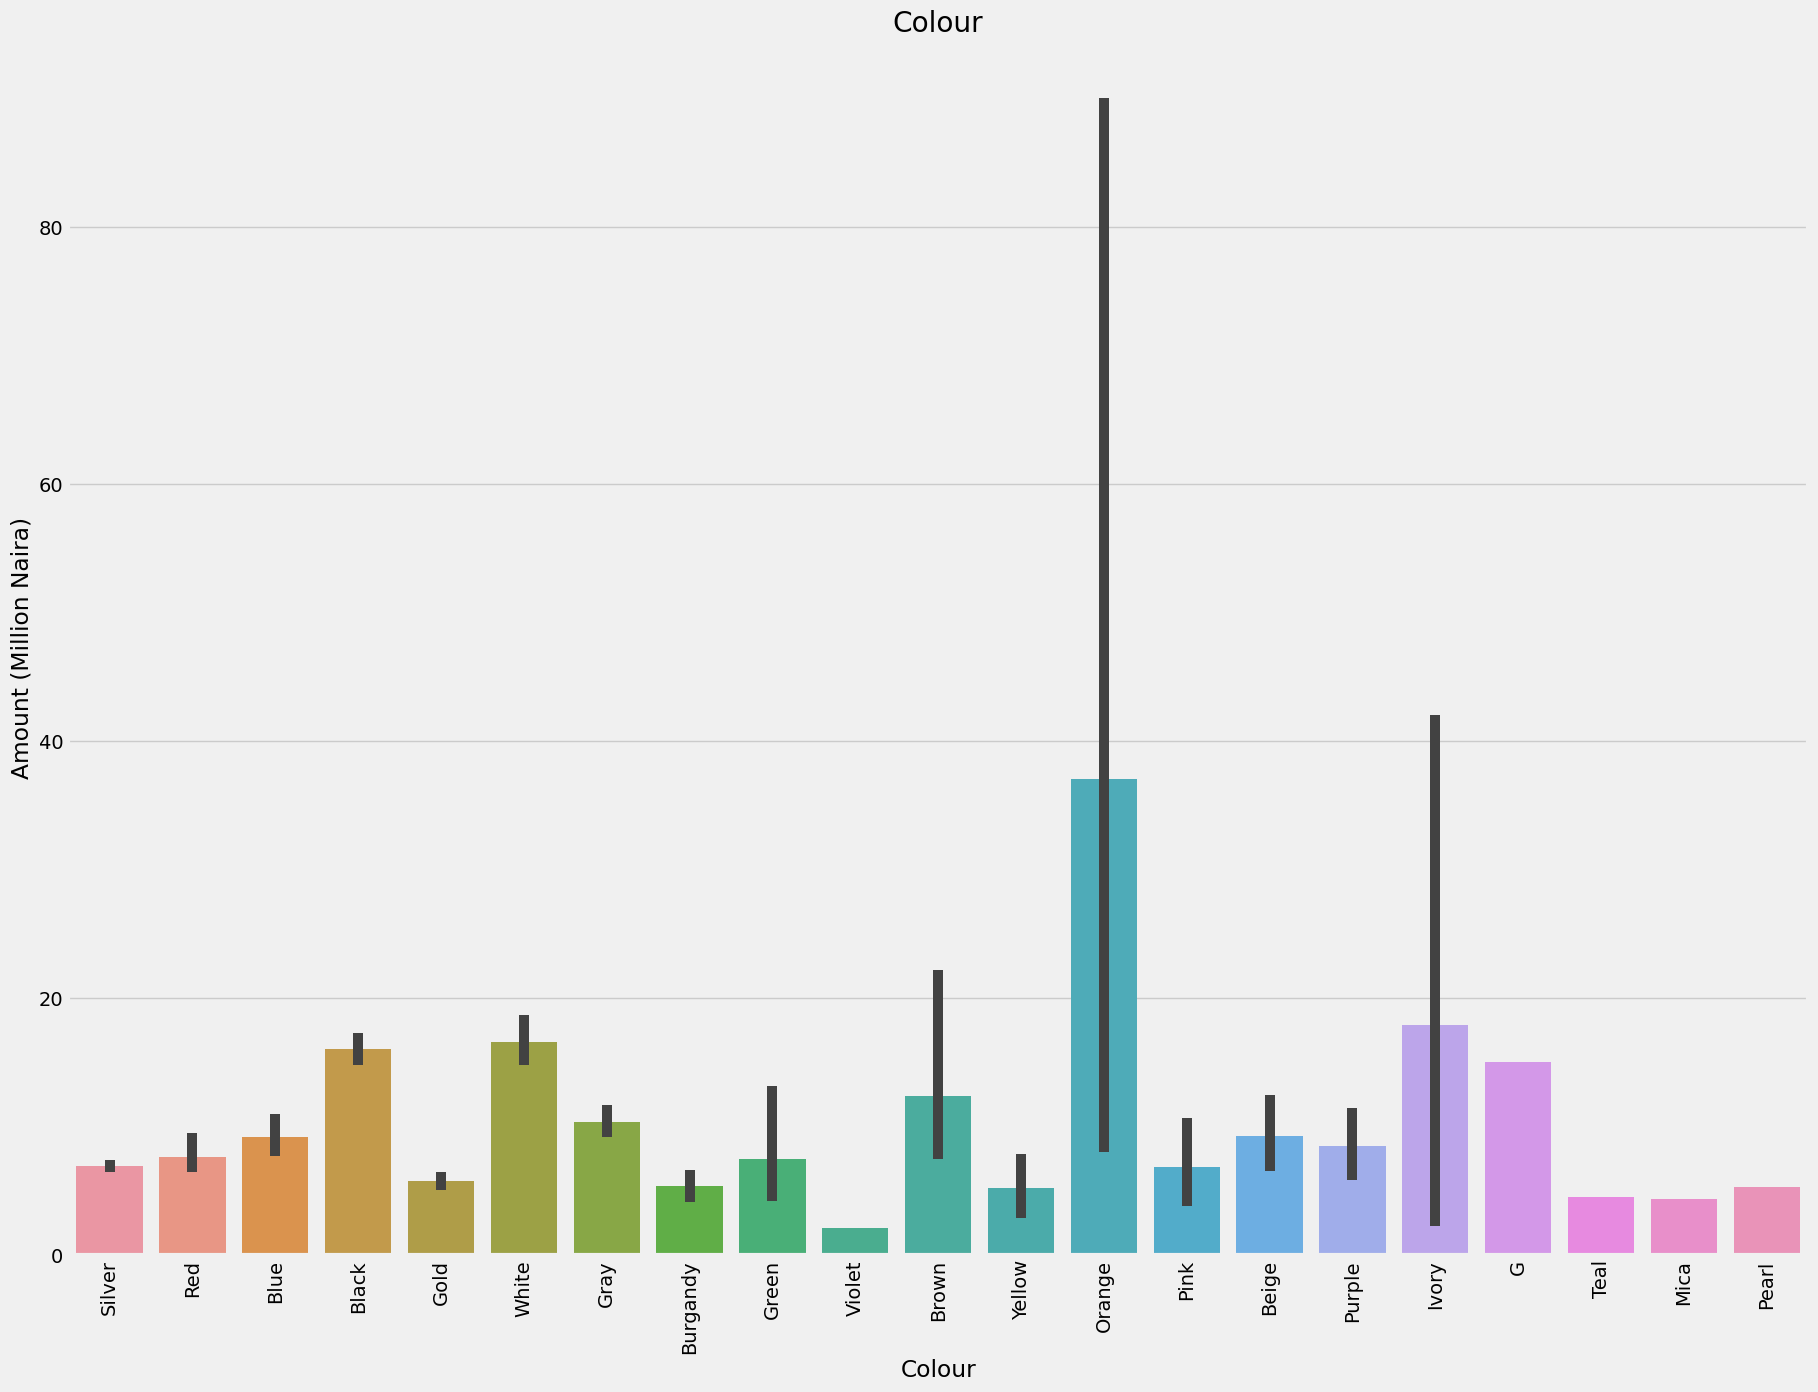

In [14]:
def plot_bar(df, feat):
    
    plt.figure(figsize=(20, 15))
    plt.title(feat)
    sns.barplot(data=df, x =feat, y='Amount (Million Naira)')
    plt.xticks(rotation=90)
    plt.show()

feat = ['Type', 'Maker', 'Colour']
for item in feat:
    plot_bar(df, item)

In [17]:
df.corr(numeric_only=True)

,Year,Amount (Million Naira),Distance
Year,1.000000,0.453122,-0.362689
Amount (Million Naira),0.453122,1.000000,-0.209315
Distance,-0.362689,-0.209315,1.000000


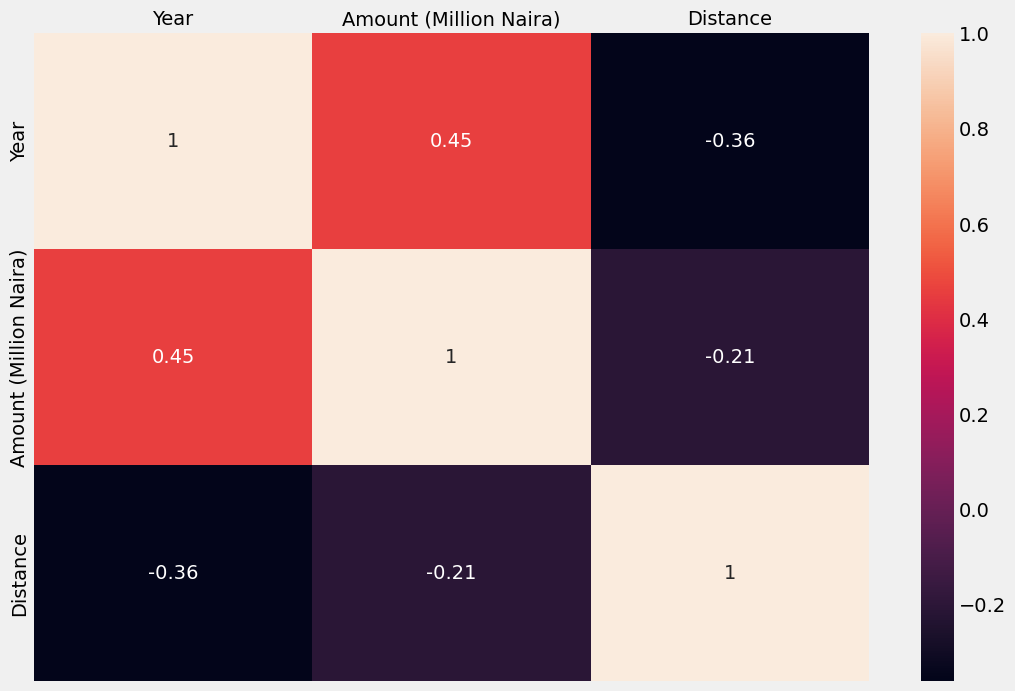

In [18]:
# heatmap of numerical variables to the target variable and to check multicolinearity
plt.figure(figsize=(12,8))
ax = sns.heatmap(df.corr(numeric_only=True), annot=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

In [19]:
def plot_scatter(df, feat):
    
    plt.figure(figsize=(20, 15))
    plt.title(feat)
    sns.scatterplot(data=df, x =feat, y='Amount (Million Naira)')
    plt.xticks(rotation=90)
    plt.show()

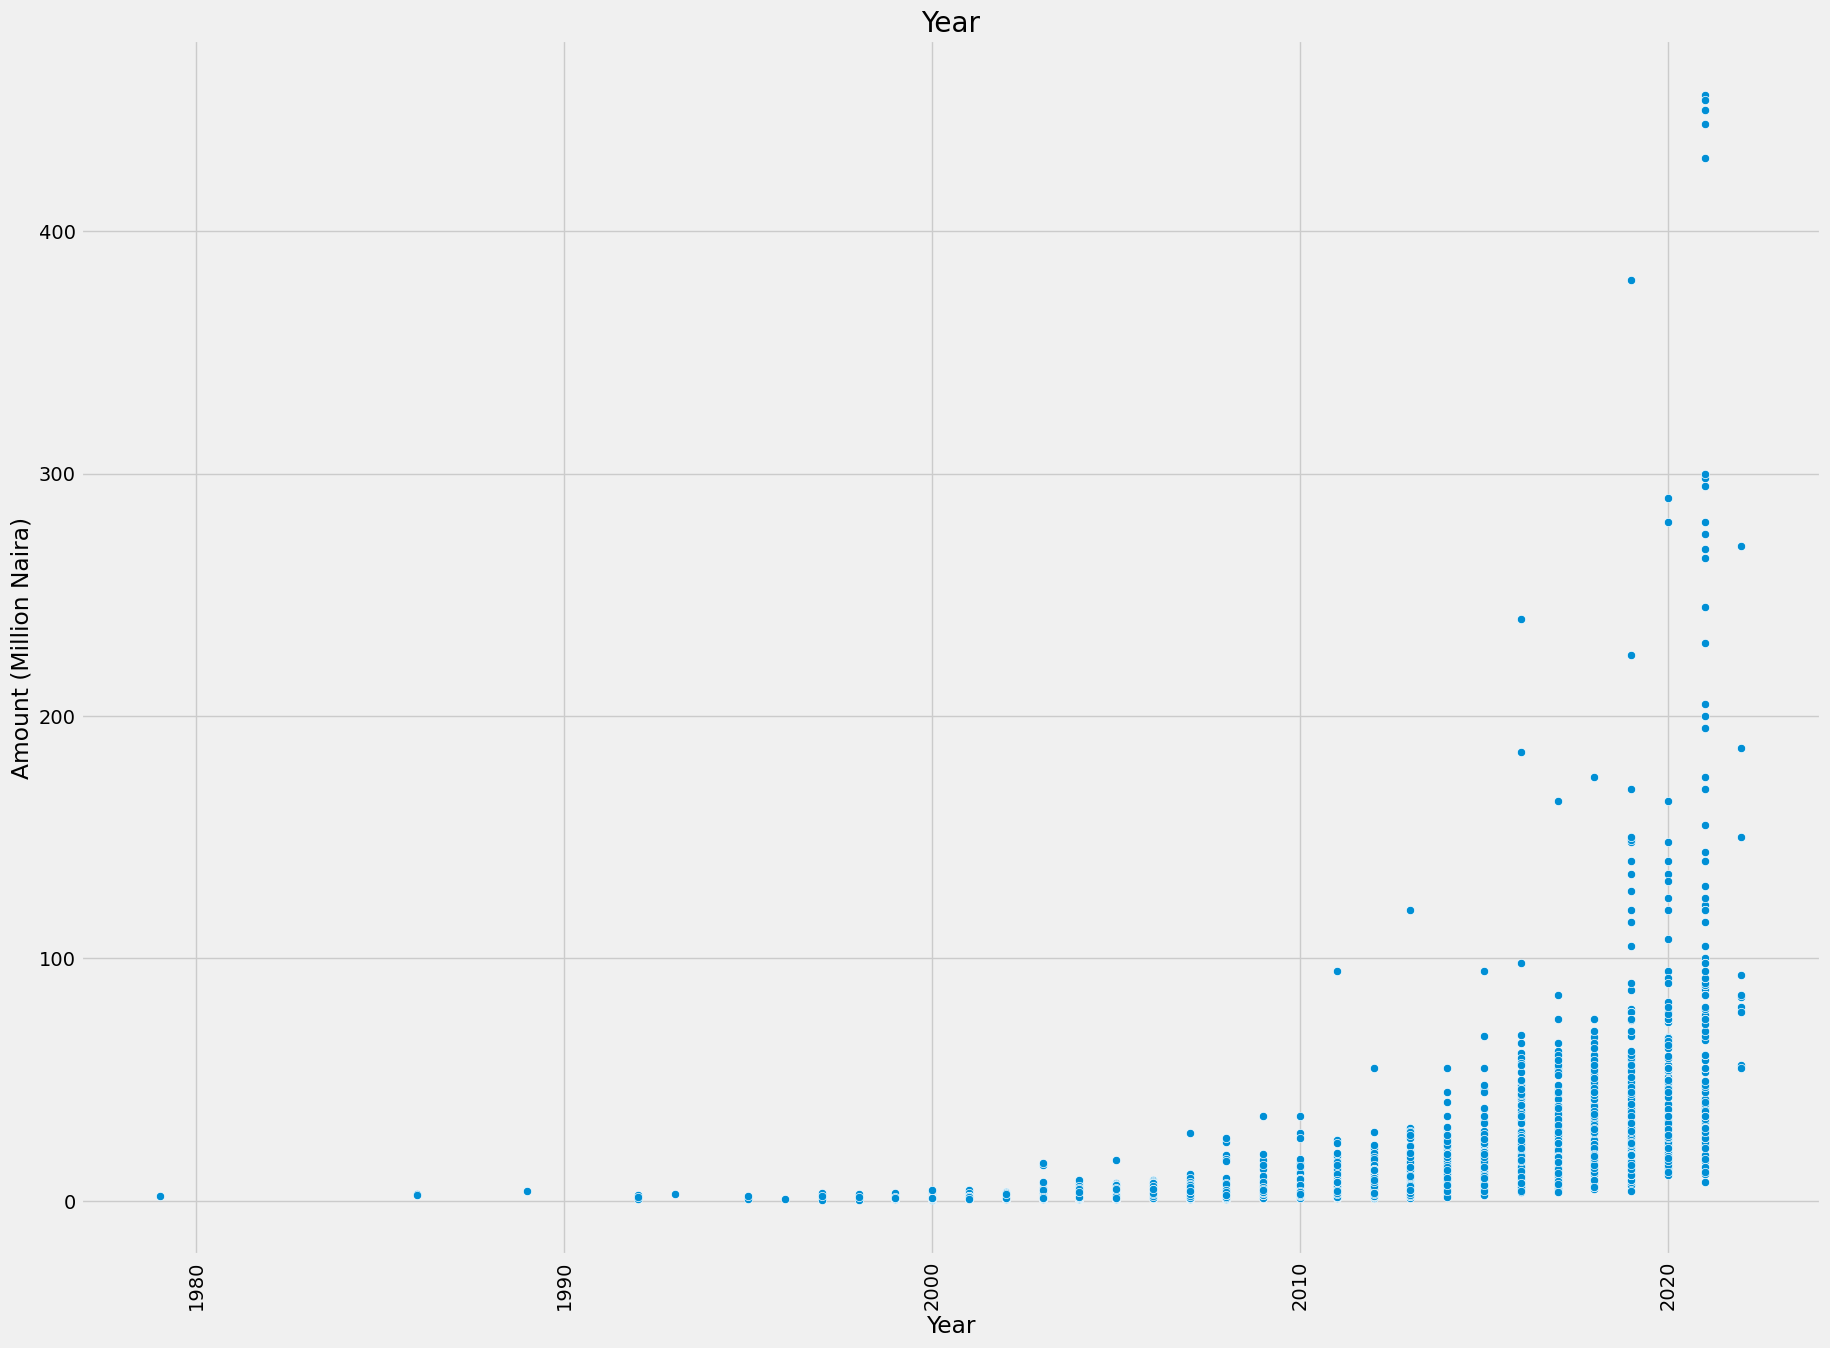

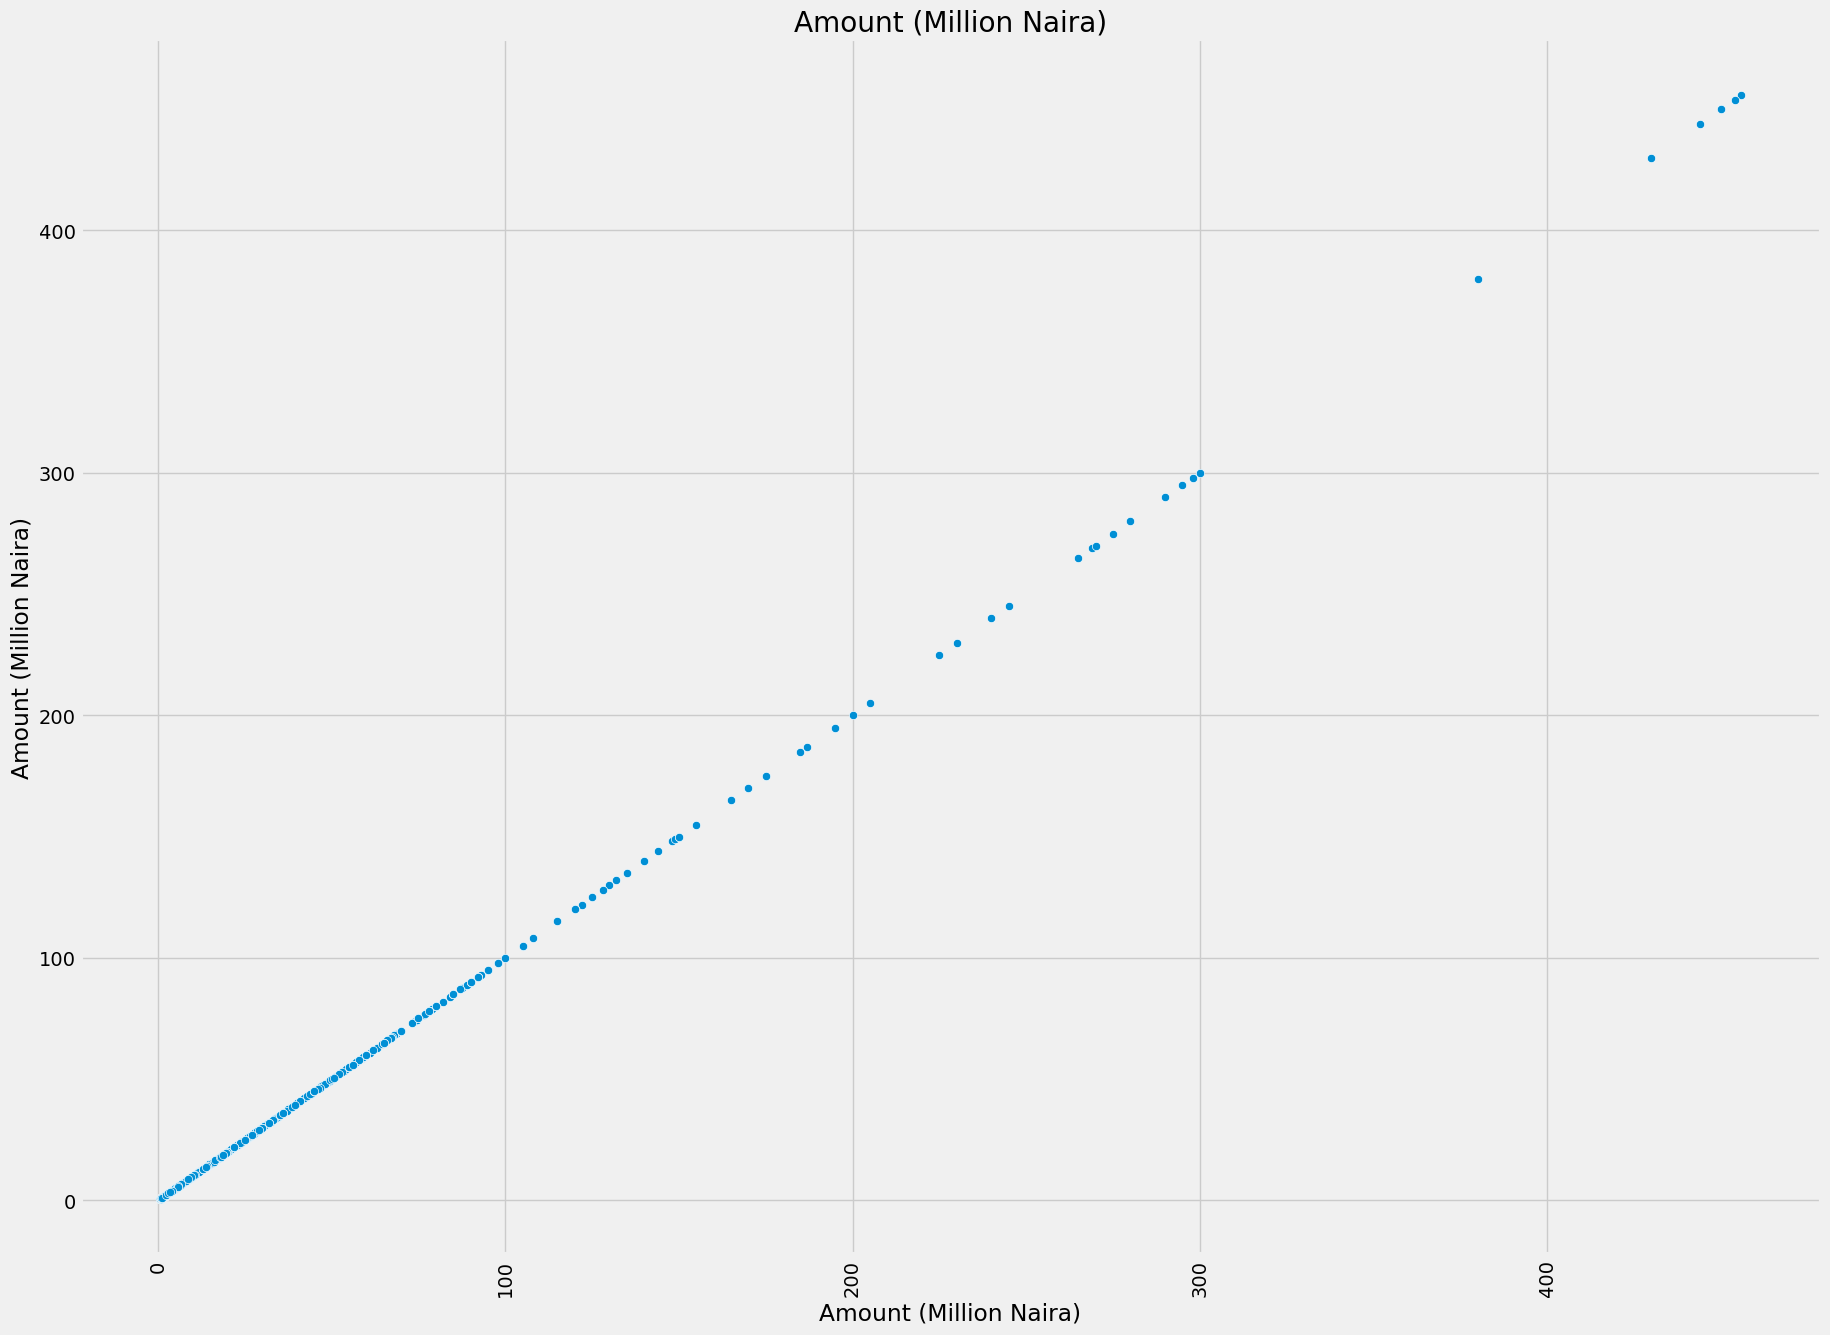

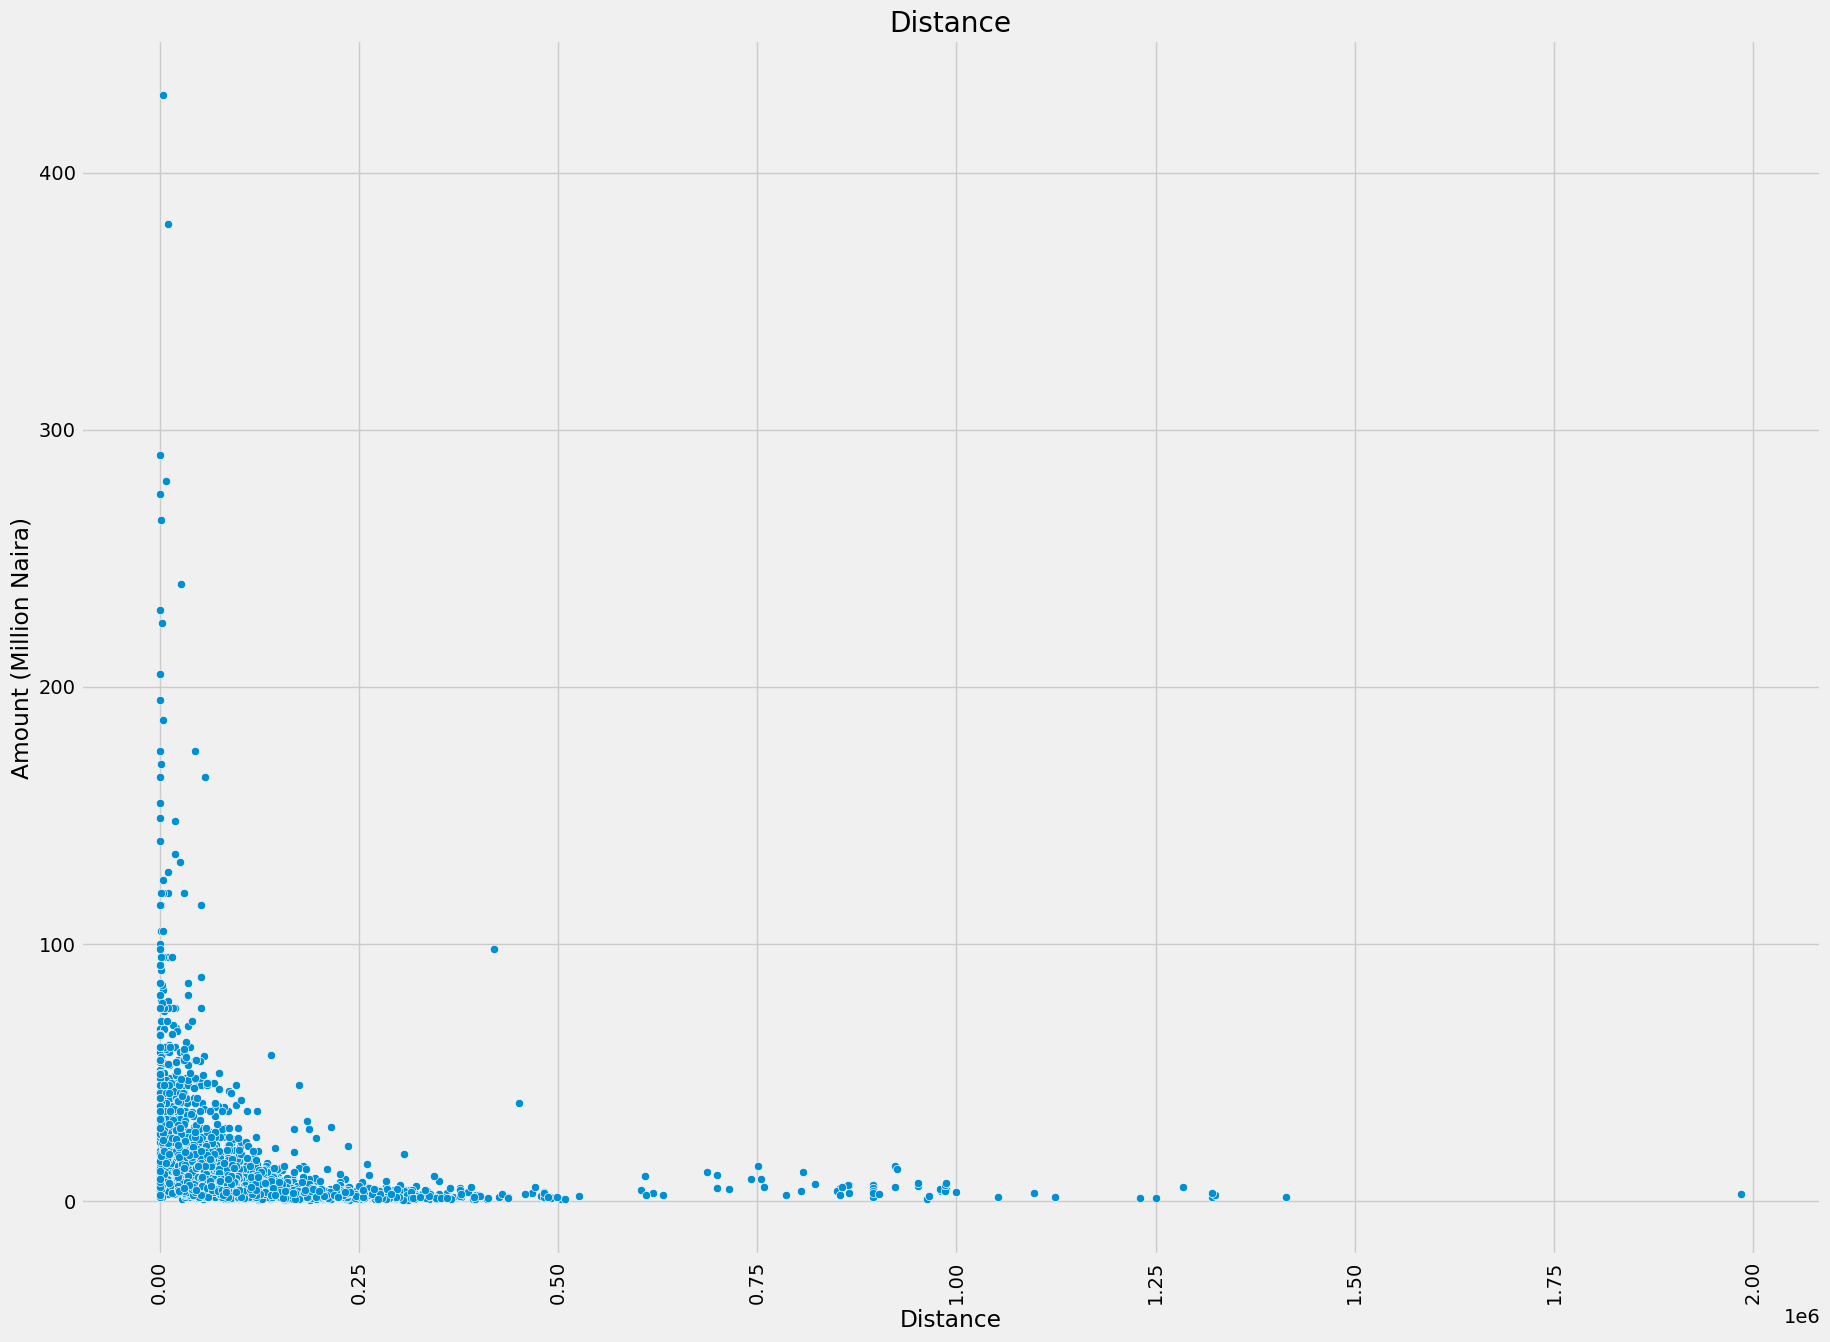

In [20]:
num_feat = [col for col in df.columns if df[col].dtypes != 'O']

for i in num_feat:
    plot_scatter(df, i)

- There is a moderate positive correlation of 0.45 between Year and Amount (Million Naira), meaning that as the year increases, the amount also tends to increase.
- There are negative correlations between Distance with both Year (-0.36) and Amount (Million Naira) (-0.21), meaning that as the distance increases, the year and the amount tend to decrease.
- The strongest correlation is between Year and Amount (Million Naira), while the weakest correlation is between Distance and Amount (Million Naira)

## Feature Engineering 

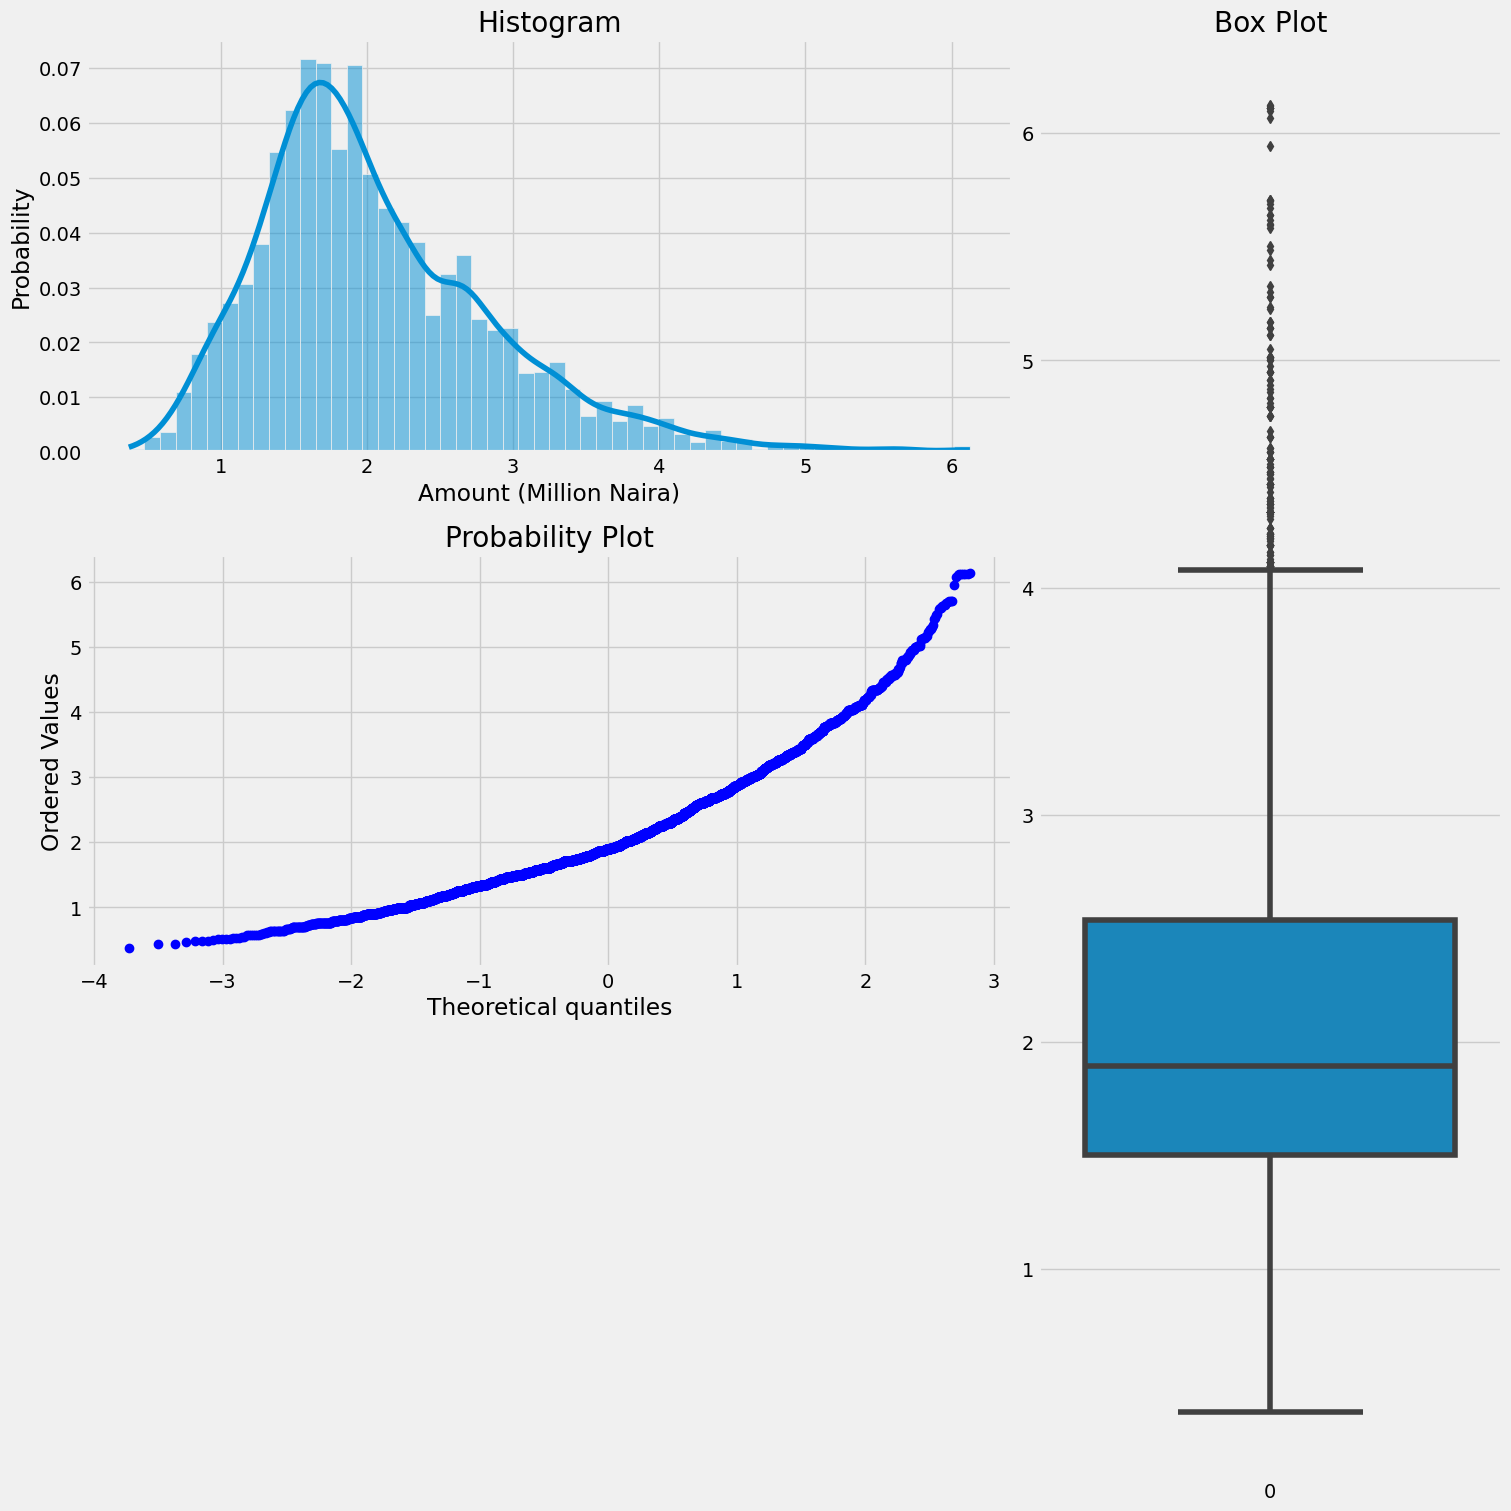

In [21]:
## trainsforming target variable using numpy.log1p

df['Amount (Million Naira)'] = np.log1p(df['Amount (Million Naira)'])
plot_figs(df, 'Amount (Million Naira)')


## Dealing with Missing Values

In [23]:
# drop missing rows of the target variable

df = df.dropna(subset=['Amount (Million Naira)']).copy()

In [25]:
# check and drop duplicate rows

df.VehicleID.nunique(), len(df)

(5129, 7188)

In [26]:
# drop duplicate rows to mae sure no vehicle exist more than once

df = df.drop_duplicates(subset=['VehicleID'])

In [27]:
# fill type column with mode

df['Type'] = df.Type.fillna(df.Type.mode()[0])
test_df['Type'] = test_df.Type.fillna(test_df.Type.mode()[0])

In [28]:
df['Year'] = df.Year.fillna(df.Year.median())
test_df['Year'] = test_df.Year.fillna(df.Year.median())

In [29]:
df['Distance'] = df.groupby('Year')['Distance'].transform(lambda x:x.fillna(x.median()))
test_df['Distance'] = test_df.groupby('Year')['Distance'].transform(lambda x:x.fillna(x.median()))
test_df.Distance.fillna(value=test_df.Distance.median(), inplace=True)

In [30]:
# scale distance variable

df['Distance'] = np.log1p(df['Distance'])
test_df['Distance'] = np.log1p(test_df['Distance'].astype(float))

# plot_figs(df, 'Distance')

In [31]:
df.dropna(inplace=True)

In [36]:
df['Age'] = 2024 - df.Year
df = df.drop(columns=['Year'])

test_df['Age'] = 2024 - test_df.Year
test_df = test_df.drop(columns=['Year'])

## Encode categorical variables

In [44]:
# Encode Categorical variables

cat_var = ['Location', 'Maker', 'Model', 'Colour', 'Type']

encoder = BinaryEncoder(cols = cat_var)

# fit the encoder to the data
encoder.fit(df)

# transform the data 
encoded_df = encoder.transform(df)

In [46]:
# Encode Categorical variables for test data

cat_var = ['Location', 'Maker', 'Model', 'Colour', 'Type']

from category_encoders import BinaryEncoder

encoder = BinaryEncoder(cols = cat_var)

# fit the encoder to the data
encoder.fit(test_df)

# transform the data 
test_encode = encoder.transform(test_df)

## Create Train and Validation dataset

In [47]:
train, val = train_test_split(encoded_df, test_size=0.25, random_state=42)

train.shape, val.shape

((3846, 29), (1282, 29))

In [48]:
X = train.drop(columns=['Amount (Million Naira)', 'VehicleID'])
y = train['Amount (Million Naira)']

X_val = val.drop(columns=['Amount (Million Naira)', 'VehicleID'])
y_val = val['Amount (Million Naira)'].to_numpy()

In [49]:
test_input = test_encode.drop(columns=['VehicleID'])

# Model Creation

I shall build four regression models and test the one with better performance to be fine tuned

In [50]:
model = LinearRegression()

model.fit(X, y)

LinearRegression()

In [55]:
# make prediction
prediction = model.predict(X_val)

# calculate rmse
accuracy = mean_squared_error(y_val, prediction, squared=False)

print(f'RMSE: {accuracy}')

RMSE: 0.40979817913191185


In [56]:
# RandomForest regressor

model_rmf = RandomForestRegressor()

# fit model
model_rmf.fit(X, y)

# make prediction
prediction_rmf = model_rmf.predict(X_val)

# calculate rmse
accuracy_rmf = mean_squared_error(y_val, prediction_rmf, squared=False)

print(f'RMSE: {accuracy_rmf}')

RMSE: 0.33129286775979855


In [58]:
# Decision Tree regressor

model_dt = DecisionTreeRegressor()

# fit model
model_dt.fit(X, y)

# make prediction
prediction_dt = model_dt.predict(X_val)

# calculate rmse
accuracy_dt = mean_squared_error(y_val, prediction_dt, squared=False)

print(f'RMSE: {accuracy_dt}')

RMSE: 0.4398841196171766


In [59]:
# KNN regressor

model_kn = KNeighborsRegressor()

# fit model
model_kn.fit(X, y)

# make prediction
prediction_kn = model_kn.predict(X_val)

# calculate rmse
accuracy_kn = mean_squared_error(y_val, prediction_kn, squared=False)

print(f'RMSE: {accuracy_kn}')

RMSE: 0.3253891076121494


In [66]:
# Define the parameters to tune
param_grid = {
    'n_neighbors': range(3, 15),  # Number of neighbors between 3 and 15
    'weights': ['uniform', 'distace'],  # wegith
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # distance metric
    'p': [1, 2, 3],  # ower parameter for minkowski metric
    'leaf_size': [10, 20, 30, 40, 50] # leaf size for the algorithm
                         }

In [67]:
# Hyperparameter tunning

# Perform grid search
grid_search = GridSearchCV(estimator=model_kn, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

# Print the best parameters
print(grid_search.best_params_)

{'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [68]:
# retrain model

best_model = grid_search.best_estimator_

# Fit the best model to the entire training set
best_model.fit(X,y)

# make prediction

prediction_bestmodel = best_model.predict(X_val)

# calculate rmse
accuracy_best = mean_squared_error(y_val, prediction_bestmodel, squared=False)

print(f'RMSE: {(accuracy_best)}')

RMSE: 0.3169892198078332


# Submission

In [69]:
test_pred = best_model.predict(test_input)

In [70]:
submission_csv = pd.read_csv('SampleSubmission.csv')

In [71]:
submission_csv['Amount (Million Naira)'] = test_pred
submission_csv.to_csv("SampleSubmission.csv", index=False)